<a href="https://colab.research.google.com/github/gasmibouthaina/Detecting-Road-Damages-From-Image-And-Video/blob/main/01DataPrep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Sources
'''
https://www.analyticsvidhya.com/blog/2021/12/how-to-use-yolo-v5-object-detection-algorithm-for-custom-object-detection-an-example-use-case/
https://github.com/ultralytics/yolov5
https://blog.paperspace.com/train-yolov5-custom-data/
https://developers.arcgis.com/python/sample-notebooks/automate-road-surface-investigation-using-deep-learning/

'''

'\nhttps://www.analyticsvidhya.com/blog/2021/12/how-to-use-yolo-v5-object-detection-algorithm-for-custom-object-detection-an-example-use-case/\nhttps://github.com/ultralytics/yolov5\nhttps://blog.paperspace.com/train-yolov5-custom-data/\nhttps://developers.arcgis.com/python/sample-notebooks/automate-road-surface-investigation-using-deep-learning/\n\n'

In [ ]:
import tarfile
from google.colab import drive
import os
from pathlib import Path
import shutil


import xml.etree.ElementTree as ET
from PIL import Image, ImageDraw

import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split

In [ ]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
root_path = r'/content/gdrive/MyDrive/ProjectDS'  #change dir to your project folder
os.chdir(root_path)

In [ ]:
os.listdir(".")

['data',
 'RoadDamageDataset',
 'assortedFiles',
 'finalRoad',
 'yolov5',
 'testing',
 '03_TestYolo.ipynb',
 '02_TrainYolo.ipynb',
 'finalRoadAshhad',
 '01DataPrep.ipynb',
 '._RoadDamageDataset']

In [ ]:
fname="data/RoadDamageDataset.tar.gz"
if fname.endswith("tar.gz"):
    tar = tarfile.open(fname, "r:gz")
    tar.extractall()
    tar.close()
elif fname.endswith("tar"):
    tar = tarfile.open(fname, "r:")
    tar.extractall()
    tar.close()

In [ ]:
# os.mkdir("./assortedFiles")
# os.mkdir("./assortedFiles/images")
# os.mkdir("./assortedFiles/labels")


In [ ]:
# len(os.listdir(input_path/fl/'Annotations'))

In [ ]:
input_path = Path("RoadDamageDataset")
output_path = Path("assortedFiles")


In [ ]:

try:
    if not os.path.exists(output_path/'images') and os.path.exists(output_path/'labels'):
        os.mkdir(output_path/'images')
        os.mkdir(output_path/'labels')
except: raise


for fl in os.listdir(input_path):
    
    if not(fl.startswith(".")):
        print("Going for ",fl)
        count=0
        num_files=len(os.listdir(input_path/fl/'Annotations'))       
        for f in os.listdir(input_path/fl/'Annotations'):
                 
            
            if not(f.startswith(".")):
                img_name = f.split('.')[0] + '.jpg'
                
                shutil.copyfile(input_path/fl/'JPEGImages'/img_name, output_path/'images'/img_name)
                shutil.copyfile(input_path/fl/'Annotations'/f, output_path/'labels'/f)

                count+=1
                if count%500==0:
                    print(count,"/",num_files,"done")



Going for  Chiba
Going for  Sumida
500 / 2278 done
1000 / 2278 done
Going for  Muroran


In [ ]:
len(os.listdir(os.path.join(output_path,"annotations")))

0

In [ ]:
output_path

PosixPath('assortedFiles')

In [ ]:
# os.listdir(os.path.join(output_path,"annotations"))

### Add the code to extract annotations

In [ ]:
# Function to get the data from XML Annotation
def extract_info_from_xml(xml_file):
    root = ET.parse(xml_file).getroot()
    
    # Initialise the info dict 
    info_dict = {}
    info_dict['bboxes'] = []

    # Parse the XML Tree
    for elem in root:
        # Get the file name 
        if elem.tag == "filename":
            info_dict['filename'] = elem.text
            
        # Get the image size
        elif elem.tag == "size":
            image_size = []
            for subelem in elem:
                image_size.append(int(subelem.text))
            
            info_dict['image_size'] = tuple(image_size)
        
        # Get details of the bounding box 
        elif elem.tag == "object":
            bbox = {}
            for subelem in elem:
                if subelem.tag == "name":
                    bbox["class"] = subelem.text
                    
                elif subelem.tag == "bndbox":
                    for subsubelem in subelem:
                        bbox[subsubelem.tag] = int(subsubelem.text)            
            info_dict['bboxes'].append(bbox)
    
    return info_dict

# Convert the info dict to the required yolo format and write it to disk
def convert_to_yolov5(info_dict):
    print_buffer = []
    
    # For each bounding box
    for b in info_dict["bboxes"]:
        try:
            class_id = class_name_to_id_mapping[b["class"]]
        except KeyError:
            print("Invalid Class. Must be one from ", class_name_to_id_mapping.keys())
        
        # Transform the bbox co-ordinates as per the format required by YOLO v5
        b_center_x = (b["xmin"] + b["xmax"]) / 2 
        b_center_y = (b["ymin"] + b["ymax"]) / 2
        b_width    = (b["xmax"] - b["xmin"])
        b_height   = (b["ymax"] - b["ymin"])
        
        # Normalise the co-ordinates by the dimensions of the image
        if len(info_dict["image_size"] )==3:
            image_w, image_h, image_c = info_dict["image_size"]  
        elif len(info_dict["image_size"] )==2:
            image_w, image_h = info_dict["image_size"]  
        b_center_x /= image_w 
        b_center_y /= image_h 
        b_width    /= image_w 
        b_height   /= image_h 
        
        #Write the bbox details to the file 
        print_buffer.append("{} {:.3f} {:.3f} {:.3f} {:.3f}".format(class_id, b_center_x, b_center_y, b_width, b_height))
        
    # Name of the file which we have to save 
    save_file_name = os.path.join("assortedFiles/annotations", info_dict["filename"].replace("jpg", "txt"))
    # print(print_buffer)
    # print(save_file_name)
    # Save the annotation to disk
    print("\n".join(print_buffer), file= open(save_file_name, "w"))

def plot_bounding_box(image, annotation_list):
    annotations = np.array(annotation_list)
    w, h = image.size
    
    plotted_image = ImageDraw.Draw(image)

    transformed_annotations = np.copy(annotations)
    transformed_annotations[:,[1,3]] = annotations[:,[1,3]] * w
    transformed_annotations[:,[2,4]] = annotations[:,[2,4]] * h 
    
    transformed_annotations[:,1] = transformed_annotations[:,1] - (transformed_annotations[:,3] / 2)
    transformed_annotations[:,2] = transformed_annotations[:,2] - (transformed_annotations[:,4] / 2)
    transformed_annotations[:,3] = transformed_annotations[:,1] + transformed_annotations[:,3]
    transformed_annotations[:,4] = transformed_annotations[:,2] + transformed_annotations[:,4]
    
    for ann in transformed_annotations:
        obj_cls, x0, y0, x1, y1 = ann
        plotted_image.rectangle(((x0,y0), (x1,y1)))
        
        plotted_image.text((x0, y0 - 10), class_id_to_name_mapping[(int(obj_cls))])
    
    plt.imshow(np.array(image))
    plt.show()    

In [ ]:
class_name_to_id_mapping={
    'D00': 0,
 'D01': 1,
 'D10': 2,
 'D11': 3,
 'D20': 4,
 'D30': 5,
 'D40': 6,
 'D43': 7,
 'D44': 8}

label_files_location="assortedFiles/labels/"
image_files_location="assortedFiles/images/"

if not os.path.isdir("assortedFiles/annotations/"):
    os.mkdir("assortedFiles/annotations/")


for l_file in os.listdir(label_files_location):
    info_dict=extract_info_from_xml(label_files_location+l_file)
    convert_to_yolov5(info_dict)
    
print("Done")

Done


### Check if annotation done correctly

[[4.0, 0.161, 0.727, 0.185, 0.243], [2.0, 0.42, 0.924, 0.227, 0.052], [2.0, 0.443, 0.826, 0.313, 0.055], [2.0, 0.372, 0.726, 0.192, 0.065], [1.0, 0.746, 0.839, 0.278, 0.268]]
file is  assortedFiles/images/Numazu_20170906131352.jpg


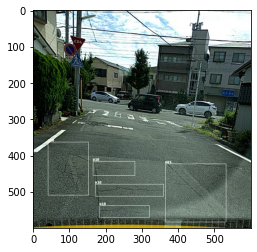

In [ ]:


class_id_to_name_mapping = dict(zip(class_name_to_id_mapping.values(), class_name_to_id_mapping.keys()))



# Get any random annotation file 
# annotation_file = random.choice(annotations)

annotation_file = "assortedFiles/annotations/Numazu_20170906131352.txt"
with open(annotation_file, "r") as file:
    annotation_list = file.read().split("\n")[:-1]
    annotation_list = [x.split(" ") for x in annotation_list]
    annotation_list = [[float(y) for y in x ] for x in annotation_list]
    print(annotation_list)

#Get the corresponding image file
image_file = annotation_file.replace("annotations", "images").replace("txt", "jpg")
print("file is ",image_file)
assert os.path.exists(image_file)

#Load the image
image = Image.open(image_file)

#Plot the Bounding Box
plot_bounding_box(image, annotation_list)

In [ ]:
# Read images and annotations
images = [os.path.join('assortedFiles/images', x) for x in os.listdir('assortedFiles/images')]
annotations = [os.path.join('assortedFiles/annotations', x) for x in os.listdir('assortedFiles/annotations') if x[-3:] == "txt"]

images.sort()
annotations.sort()

In [ ]:
print(len(images),len(annotations))

9053 9053


In [ ]:
# Split the dataset into train-valid-test splits 
train_images, val_images, train_annotations, val_annotations = train_test_split(images, annotations, test_size = 0.2, random_state = 1)
val_images, test_images, val_annotations, test_annotations = train_test_split(val_images, val_annotations, test_size = 0.5, random_state = 1)

In [ ]:
#Create the folders to keep the splits.

In [ ]:
!mkdir finalRoad
!mkdir finalRoad/images
!mkdir finalRoad/annotations

!mkdir finalRoad/images/train finalRoad/images/val finalRoad/images/test finalRoad/annotations/train finalRoad/annotations/val finalRoad/annotations/test

mkdir: cannot create directory ‘finalRoad’: File exists
mkdir: cannot create directory ‘finalRoad/images’: File exists
mkdir: cannot create directory ‘finalRoad/annotations’: File exists
mkdir: cannot create directory ‘finalRoad/images/train’: File exists
mkdir: cannot create directory ‘finalRoad/images/val’: File exists
mkdir: cannot create directory ‘finalRoad/images/test’: File exists
mkdir: cannot create directory ‘finalRoad/annotations/train’: File exists
mkdir: cannot create directory ‘finalRoad/annotations/val’: File exists
mkdir: cannot create directory ‘finalRoad/annotations/test’: File exists


In [ ]:

#Utility function to move images 
def move_files_to_folder(list_of_files, destination_folder):
    for f in list_of_files:
        # print(f,destination_folder)
        try:
            shutil.move(f, destination_folder)
        except:
            pass
            # print(f,"Already there")
            # assert False

# Move the splits into their folders
move_files_to_folder(train_images, ' finalRoad/images/train/')
move_files_to_folder(val_images, 'finalRoad/images/val/')
move_files_to_folder(test_images, 'finalRoad/images/test/')
move_files_to_folder(train_annotations, 'finalRoad/annotations/train/')
move_files_to_folder(val_annotations, 'finalRoad/annotations/val/')
move_files_to_folder(test_annotations, 'finalRoad/annotations/test/')


In [ ]:
os.listdir(".")

['01DataPrep.ipynb',
 '._RoadDamageDataset',
 'data',
 'RoadDamageDataset',
 'assortedFiles',
 'outputs',
 'yolov5',
 'finalRoad',
 '02_TrainYolo']

In [ ]:
len(os.listdir("finalRoad/annotations/train"))

7242

In [ ]:
# os.listdir("/content/gdrive/MyDrive/work/research/from_gpu/other_misc/gasmi/finalRoad/images/val")

In [ ]:
! mv finalRoad/annotations finalRoad/labels